In [1]:
%matplotlib inline


Deconvolution
=============
Neuroscientists (amongst others) are often interested in time series that are derived
from neural activity, such as fMRI BOLD and pupil dilation. However, for some classes
of data, neural activity gets temporally delayed and 
dispersed. This means that if the time series is related to some behavioral events that 
are close together in time, these event-related responses will contaminate each other.




In [2]:
# Import libraries and set up plotting
import nideconv
from nideconv import simulate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
palette = sns.color_palette('Set1')

/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/gilles/miniconda3/envs/nideconv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Simulate data
-------------
We simulate fMRI data with a "cue - stimulus" design.
There are four cues and corresponding stimulus presentations.
The cue is always followed by a stimulus, seperated in time by 
1, 2, 3, or 4 seconds.
The cue leads to a small de-activation (0.5 % signal change), the stimulus to an
activation (1.0 % signal change).



In [31]:
cue_onsets = [5, 15, 25, 35]
stim_onsets = [6, 17, 28, 39]

cue_pars = {'name':'cue',
            'mu_group':-.5 * 20., # Slight negative response for cue
            'std_group':0,
            'onsets':cue_onsets,
            'kernel':'gamma'}

stim_pars = {'name':'stim',
             'mu_group':1 * 20., # Positive response for stimulus presentation
             'std_group':0,
             'onsets':stim_onsets}

conditions = [cue_pars,
              stim_pars]

data, onsets, parameters = simulate.simulate_fmri_experiment(conditions,
                                                             run_duration=60)

data /= 20.

In [32]:
parameters

kernel           onsets  amplitude
subject trial_type                                          
1       cue                gamma  [5, 15, 25, 35]      -10.0
        stim        double_gamma  [6, 17, 28, 39]       20.0

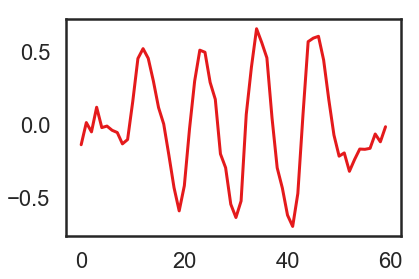

In [33]:
plt.plot(data)

Underlying data-generating model
--------------------------------
Because we simulated the data, we know that the event-related responses should
exactly follow the *canonical Hemodynamic Response Function* [1]_are



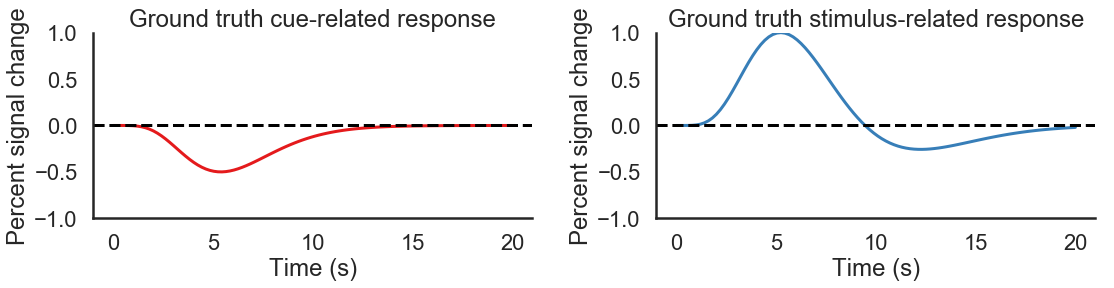

In [60]:
from nideconv.utils import double_gamma_with_d, gamma
import numpy as np

plt.figure(figsize=(16., 4.5))

t = np.linspace(0, 20, 100)
ax1 = plt.subplot(121)
plt.title('Ground truth cue-related response')
plt.plot(t, gamma(t) * -.5,
         color=palette[0])
plt.xlabel('Time (s)')
plt.ylabel('Percent signal change')
plt.axhline(0, c='k', ls='--')

plt.subplot(122, sharey=ax1)
plt.title('Ground truth stimulus-related response')
plt.plot(t, double_gamma_with_d(t),
         color=palette[1])
plt.axhline(0, c='k', ls='--')
plt.xlabel('Time (s)')
plt.ylabel('Percent signal change')
ax1.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
ax1.set_ylim(-1., 1.0)
sns.despine()
plt.tight_layout()

plt.savefig('/Users/gilles/nideconv/ground_truth.pdf', transparent=True)

Plot simulated data
-------------------



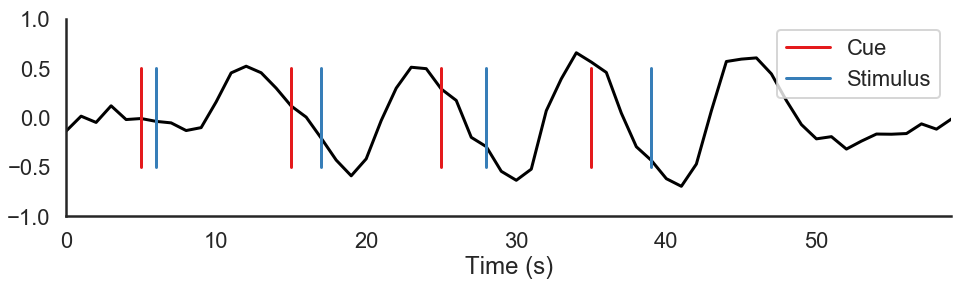

In [61]:
data.plot(c='k')
sns.despine()

for onset in cue_onsets:
    l1 =plt.axvline(onset, c=palette[0], ymin=.25, ymax=.75)

for onset in stim_onsets:
    l2 =plt.axvline(onset, c=palette[1], ymin=.25, ymax=.75)


plt.gcf().set_size_inches(14., 4.5)
plt.legend([l1, l2], ['Cue', 'Stimulus'])
plt.tight_layout()
plt.xlabel('Time (s)')
plt.yticks([-1.0, -0.5, 0, 0.5, 1.0])
plt.ylim(-1.0, 1.0)

plt.savefig('/Users/gilles/nideconv/simulated_data.pdf', transparent=True)

Naive approach: epoched averaging
---------------------------------
A simple approach that is appropriate for fast electrphysiological signals
like EEG and MEG, but not necessarily fMRI, would be to select little chunks of the 
time series, corresponding to the onset of the events-of-interest and the subsequent
20 seconds of signal ("epoching").



We can do such a epoch-analysis using nideconv, by making a ResponseFitter
object and using the `get_epochs()`-function:



In [62]:
import pandas as pd

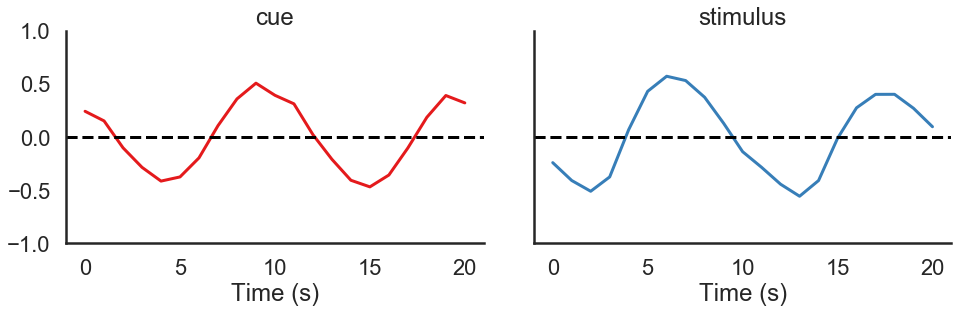

In [69]:
rf =nideconv.ResponseFitter(input_signal=data,
                            sample_rate=1)

cue_epochs = rf.get_epochs(onsets=onsets.loc['cue'].onset, 
                           interval=[0, 20])

stim_epochs = rf.get_epochs(onsets=onsets.loc['stim'].onset, 
                           interval=[0, 20])

cue_epochs = cue_epochs.mean()['signal'].to_frame('value').reset_index()
cue_epochs['event_type'] = 'cue'
stim_epochs = stim_epochs.mean()['signal'].to_frame('value').reset_index()
stim_epochs['event_type'] = 'stimulus'

epochs = pd.concat((cue_epochs, stim_epochs))

# sns.lineplot('time', 'value', data=cue_epochs.mean()['signal'].to_frame('value').reset_index())
sns.set_palette(palette)
fac = sns.FacetGrid(epochs, col='event_type', hue='event_type', aspect=14/2./4.5, height=4.5)
fac.map(sns.lineplot, 'time', 'value', )

fac.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))
fac.set_titles("{col_name}")  # use this argument literally


plt.yticks([-1.0, -0.5, 0, 0.5, 1.0])
plt.ylim(-1., 1.0)
fac.set(xlabel='Time (s)')
plt.savefig('/Users/gilles/nideconv/epochs.pdf', transparent=True)


Now we have a 4 x 21 DataFrame of epochs, that we can all plot 
in the same figure:



We can do the same for the stimulus-locked responses:



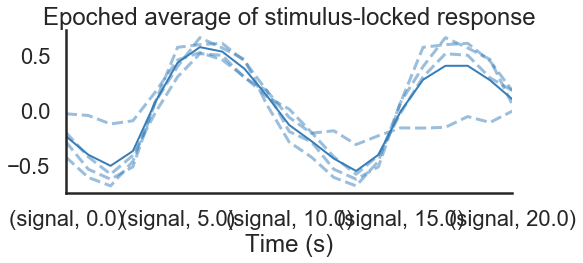

In [38]:
stim_epochs = rf.get_epochs(onsets=onsets.loc['stim'].onset, 
                           interval=[0, 20])
stim_epochs.T.plot(c=palette[1], alpha=.5, ls='--', legend=False)
stim_epochs.mean().plot(c=palette[1], lw=2, alpha=1.0)
sns.despine()
plt.xlabel('Time (s)')
plt.title('Epoched average of stimulus-locked response')
plt.gcf().set_size_inches(8, 3)

Contamination
~~~~~~~~~~~~~
As you can see, when we use epoched averaging, both the cue- and 
stimulus-related response are *contaminated*  by adjacent responses (from 
both response types). The result is some sinewave-like pattern that
has little to do with the data-generating response functions of
both cue- and stimulus-related activity



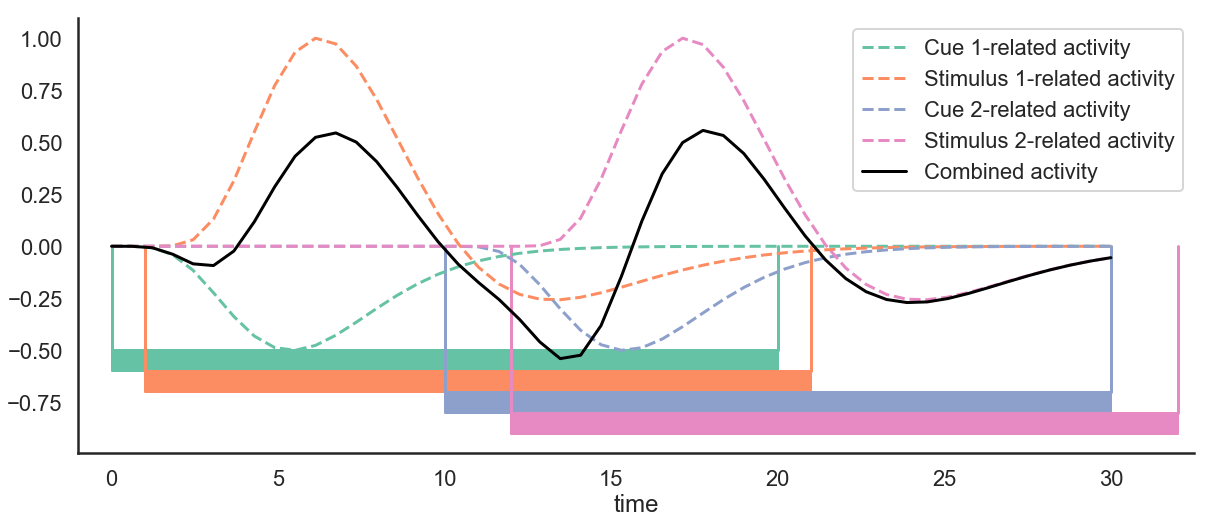

In [39]:
# This is because the event-related responses are overlapping in time: 
from nideconv.utils import double_gamma_with_d

t = np.linspace(0, 30)

cue1_response = gamma(t) * -.5
stim1_response = double_gamma_with_d(t-1)

cue2_response = gamma(t-10) * -.5
stim2_response = double_gamma_with_d(t-12)

palette2 = sns.color_palette('Set2')

plt.fill_between([0, 20],  -.5, -.6, color=palette2[0])
plt.plot([[0, 20], [0, 20]], [-.5, 0], color=palette2[0])
plt.fill_between([1, 21],  -.6, -.7, color=palette2[1])
plt.plot([[1, 21], [1, 21]], [-.6, 0], color=palette2[1])
plt.fill_between([10, 30],  -.7, -.8, color=palette2[2])
plt.plot([[10, 30], [10, 30]], [-.7, 0], color=palette2[2])
plt.fill_between([12, 32],  -.8, -.9, color=palette2[3])
plt.plot([[12, 32], [12, 32]], [-.8, 0], color=palette2[3])
            

plt.plot(t, cue1_response, c=palette2[0], ls='--', label='Cue 1-related activity')
plt.plot(t, stim1_response, c=palette2[1], ls='--', label='Stimulus 1-related activity')

plt.plot(t, cue2_response, c=palette2[2], ls='--', label='Cue 2-related activity')
plt.plot(t, stim2_response, c=palette2[3], ls='--', label='Stimulus 2-related activity')

plt.plot(t, cue1_response + \
            stim1_response + \
            cue2_response + \
            stim2_response, 
         c='k', label='Combined activity')
plt.legend()
sns.despine()
plt.gcf().set_size_inches(20, 8)
plt.xlim(-1, 32.5)
# plt.title('Illustration of overlap problem')
plt.xlabel('time')

plt.savefig('/Users/gilles/nideconv/problem.pdf', transparent=True)

Solution: the Genera Linear Model
---------------------------------
An often-used solution to the "overlap problem" is to assume a 
`linear time-invariant system 
<https://en.wikipedia.org/wiki/Linear_time-invariant_theory>`_. 
This means that you assume that overlapping responses influencing time point
$t$ add up linearly.
Assuming this linearity, the deconvolution boils down to solving a linear
sytem: every timepoint $y_t$ from signal $Y$ is a linear 
combination of the overlapping responses, modeled by corresponding row
of matrix $X$, $X_{t,...}$ (note that the design of matrix
$X$ is crucial here but more on that later...). 
We just need to find the 'weights' of the responses $\beta$.:

\begin{align}Y = X\beta\end{align}

We can do this using a General Linear Model (GLM) and its closed-form solution
ordinary least-squares (OLS).

\begin{align}\hat{\beta} = (X^TX)^{-1} X^TY\end{align}

This solution is part of the main functionality of nideconv. 
and can be applied by creating a `ResponseFitter`-object:



In [40]:
rf =nideconv.ResponseFitter(input_signal=data,
                            sample_rate=1)

To which the events-of-interest can be added as follows:



In [41]:
rf.add_event(event_name='cue', 
             onset_times=onsets.loc['cue'].onset,
             interval=[0,20])
rf.add_event(event_name='stimulus', 
             onset_times=onsets.loc['stim'].onset,
             interval=[0,20])

Nideconv aumatically creates a design matrix.
By default, it does so using 'Finite Impulse
Response'-regressors (FIR). Each one of these regressors corresponds
to a different event and temporal offset. Such a  design matrix looks like this:



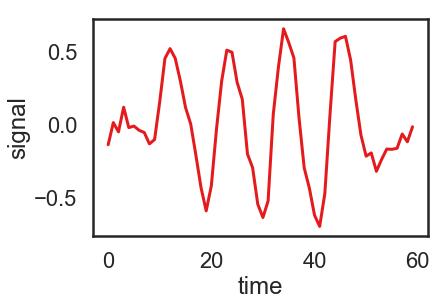

In [42]:
sns.lineplot('time', 'signal', data=data.reset_index())

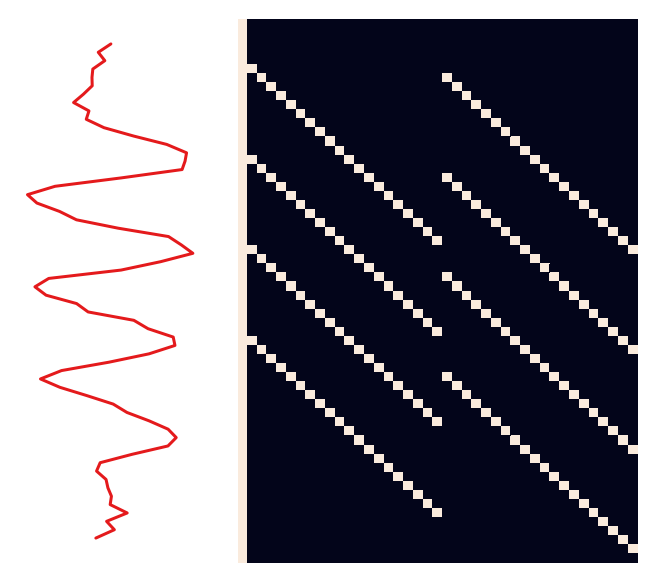

In [43]:
fig, axes = plt.subplots(1, 2)

ax1 = plt.subplot2grid((3, 4), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((3, 4), (0, 1), colspan=2, rowspan=3)


ax1.plot(data['signal'], data.index)
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.set_xlabel('signal', rotation='vertical')
# ax2.set_xticks([5, 10], ['cue', 'stim'])


sns.heatmap(rf.X.values, ax=ax2, xticklabels=False, yticklabels=False, cbar=False)

sns.despine(fig=fig, left=True, bottom=True)


fig.set_size_inches(15, 10)
plt.savefig('/Users/gilles/nideconv/glm.pdf', transparent=True)

In [44]:
import warnings
warnings.filterwarnings('ignore')

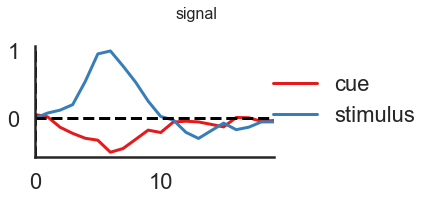

In [45]:
import nideconv
rf = nideconv.ResponseFitter(input_signal=data,
                            sample_rate=1)
rf.add_event(event_name='cue', 
             onset_times=onsets.loc['cue'].onset,
             basis_set='fir',
             interval=[0,20])
rf.add_event(event_name='stimulus', 
             onset_times=onsets.loc['stim'].onset,
             basis_set='fir',             
             interval=[0,20])
rf.regress()
rf.plot_timecourses()

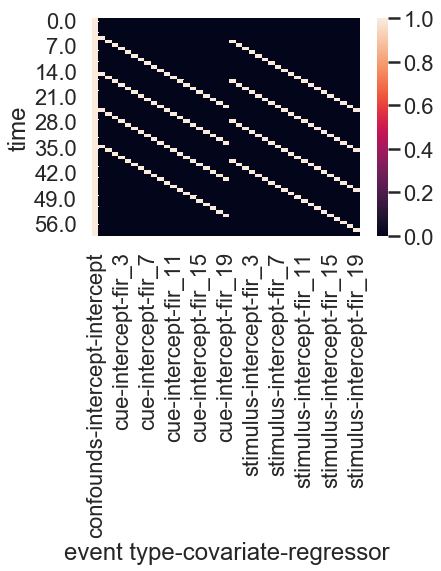

In [46]:
sns.heatmap(rf.X)
# print(rf.X)

plt.savefig('/Users/gilles/nideconv/design_matrix.pdf')

(Note the hierarchical columns (event type / covariate / regressor) 
on the regressors)



Now we can solve this linear system using ordinary least squares:



In [47]:
rf.regress()
print(rf.betas)

                                  signal
event type covariate regressor          
confounds  intercept intercept -0.028512
cue        intercept fir_0      0.057661
                     fir_1      0.023576
                     fir_2     -0.131099
                     fir_3     -0.221786
                     fir_4     -0.294170
                     fir_5     -0.322738
                     fir_6     -0.500826
                     fir_7     -0.446271
                     fir_8     -0.310754
                     fir_9     -0.173712
                     fir_10    -0.208901
                     fir_11    -0.053708
                     fir_12    -0.041703
                     fir_13    -0.052519
                     fir_14    -0.087961
                     fir_15    -0.125776
                     fir_16     0.013532
                     fir_17     0.009582
                     fir_18    -0.043706
                     fir_19    -0.031550
stimulus   intercept fir_0      0.003453
                

Importantly, with nideconv it is also very easy to 'convert` these 
beta-estimates to the found event-related time courses, at a higher temporal
resolution:



In [48]:
tc =rf.get_timecourses()
print(tc)

                              signal
event type covariate time           
cue        intercept 0.00   0.057661
                     0.05   0.057661
                     0.10   0.057661
                     0.15   0.057661
                     0.20   0.057661
                     0.25   0.057661
                     0.30   0.057661
                     0.35   0.057661
                     0.40   0.057661
                     0.45   0.057661
                     0.50   0.057661
                     0.55   0.023576
                     0.60   0.023576
                     0.65   0.023576
                     0.70   0.023576
                     0.75   0.023576
                     0.80   0.023576
                     0.85   0.023576
                     0.90   0.023576
                     0.95   0.023576
                     1.00   0.023576
                     1.05   0.023576
                     1.10   0.023576
                     1.15   0.023576
                     1.20   0.023576
 

as well as plot these responses...



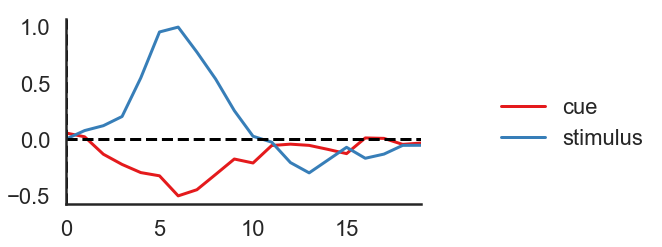

In [49]:
sns.set_palette(palette)
rf.plot_timecourses(oversample=1.)
plt.suptitle('')
# plt.title('')
# plt.legend()

plt.gcf().set_size_inches(10, 5)
plt.savefig('/Users/gilles/nideconv/result.pdf', transparent=True)

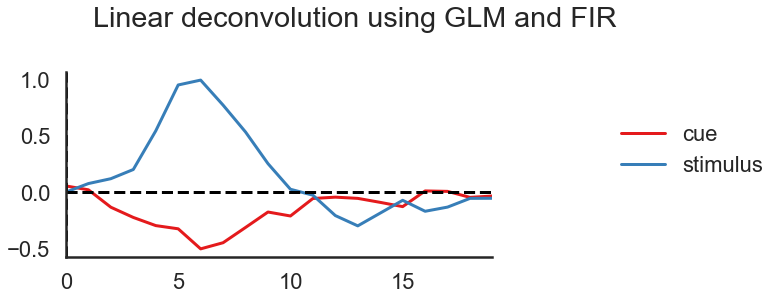

In [50]:
sns.set_palette(palette)
rf.plot_timecourses(oversample=1.)
plt.suptitle('Linear deconvolution using GLM and FIR')
plt.title('')
# plt.legend()

plt.gcf().set_size_inches(12, 5)

As you can see, these estimated responses are much closer to the 
original data-generating functions we were looking for.

Cleary, the linear deconvolution approach allows us to very quickly
and effectively 'decontaminate' overlapping responses.
Have a look at the next section () for more theory and plots
on the selection of appropriate `basis functions`.



References
-----------
.. [1] Glover, G. H. (1999). Deconvolution of impulse response in 
event-related BOLD fMRI. NeuroImage, 9(4), 416–429.



In [ ]:
from 